In [2]:
import nibabel as nib
from monai.data.utils import correct_nifti_header_if_necessary
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, BitsAndBytesConfig, AutoModelForCausalLM
import os
import numpy as np
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
image_file_path = "/import/c4dm-04/siyoul/u2Tokenizer/datasets/AMOS-MM/imagesVa/amos_0034.nii.gz"
nifti_img = nib.load(image_file_path)
nifti_img = correct_nifti_header_if_necessary(nifti_img)
img_array = nifti_img.get_fdata()
print(img_array.shape)
# mean = np.mean(img_array)
# std = np.std(img_array)
# img_array = (img_array - mean) / std
max_val = np.max(img_array)
min_val = np.min(img_array)
img_array = (img_array - min_val) / (max_val - min_val)

img_data = torch.from_numpy(img_array)
img_data = img_data.permute(2, 0, 1)  # shape: (D, H, W)
warp_img = img_data.unsqueeze(0).unsqueeze(0) 
#warp_img = warp_img.half()
warp_img = F.interpolate(warp_img, size=(32, 256, 256), mode='trilinear', align_corners=True)
warp_img = warp_img.squeeze(0).squeeze(0)
print(warp_img.max(), warp_img.min())
img_array = warp_img.numpy()
img_array = np.transpose(img_array, (2, 0, 1))
img_array = np.expand_dims(img_array, axis=0)


(512, 512, 103)
tensor(0.9934, dtype=torch.float64) tensor(0., dtype=torch.float64)


In [4]:
warp_img.shape

torch.Size([32, 256, 256])

0.9934347104348022 0.0


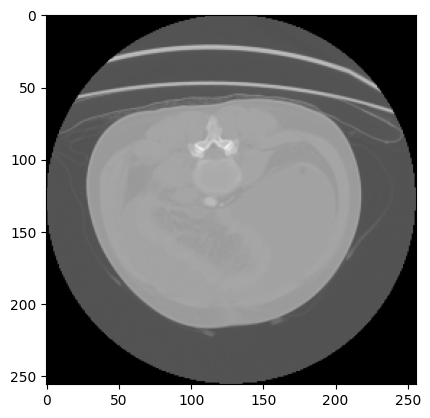

In [5]:
import matplotlib.pyplot as plt
plt.imshow(img_array[0, :, 16, :], cmap='gray')
#plt.imshow(warp_img[16, :, :], cmap='gray')
print(img_array.max(), img_array.min())

In [14]:
from peft import LoraConfig, get_peft_model

def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    # Process of elimination: LoRA only targets on LLM backbone
    ignore_keywords = ['vision_tower', 'mm_projector', 'embed_tokens', 'lm_head', 'seg_projector', 'seg_module']
    for name, module in model.named_modules():
        if any(mm_keyword in name for mm_keyword in ignore_keywords):
            continue
        if isinstance(module, cls):
            lora_module_names.add(name)
    return list(lora_module_names)

u2_model_path = "/import/c4dm-04/siyoul/u2Tokenizer/checkpoint/amosmm_chatgpt_phi2_0210@bs2_acc1_ep16_lr2e5_ws2_fused/checkpoint-132000"
def load_model(u2_model_path, enable_lora=False):
    tokenizer = AutoTokenizer.from_pretrained(
        u2_model_path,
        model_max_length=2048,
        padding_side="right",
        use_fast=False,
        pad_token="<|endoftext|>",
        trust_remote_code=True
    )
    # Define and add special tokens
    # special_token = {"additional_special_tokens": ["<|coord_9|>", "<im_patch>", "<bx_start>", "<bx_end>"]}
    # tokenizer.add_special_tokens(
    #     special_token
    # )
    # tokenizer.add_tokens("[SEG]")
    print(tokenizer.additional_special_tokens)
    print(tokenizer.additional_special_tokens_ids)
    if tokenizer.unk_token is not None and tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.unk_token
    
    if enable_lora:
        
        lora_config = LoraConfig(
            r=16,
            lora_alpha=32,
            target_modules=find_all_linear_names(u2_model),
            lora_dropout=0.05,
            bias="none",
            task_type="CAUSAL_LM",
        )
        print("Adding LoRA adapters only on LLM.")
        u2_model = get_peft_model(u2_model, lora_config)
        # u2_model.print_trainable_parameters()
        print("Load weights with LoRA")
        state_dict = torch.load(u2_model_path, map_location="cuda")
        u2_model.load_state_dict(state_dict, strict=True)
        print("Merge weights with LoRA")
        u2_model = u2_model.merge_and_unload()
    else:
        u2_model = AutoModelForCausalLM.from_pretrained(
        u2_model_path,
        trust_remote_code=True,
        )
    u2_model = u2_model.to("cpu")
    u2_model.eval()
    return tokenizer, u2_model

tokenizer, u2_model = load_model(u2_model_path)


['<im_patch>', '<bx_start>', '<bx_end>']
[50297, 50296, 50295]


Some weights of u2PhiForCausalLM were not initialized from the model checkpoint at /import/c4dm-04/siyoul/u2Tokenizer/checkpoint/amosmm_chatgpt_phi2_0210@bs2_acc1_ep16_lr2e5_ws2_fused/checkpoint-132000 and are newly initialized: ['model.seg_projector.0.bias', 'model.seg_projector.0.weight', 'model.seg_projector.2.bias', 'model.seg_projector.2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
vit_layers_params_num = 0
for name, module in u2_model.named_modules():
        if any(mm_keyword in name for mm_keyword in ["vision_tower"]):
            vit_layers_params_num += sum(p.numel() for p in module.parameters())
print(f"Total number of parameters in vision tower: {vit_layers_params_num}")
mm_projector_params_num = 0
for name, module in u2_model.named_modules():
    if any(mm_keyword in name for mm_keyword in ["mm_projector"]):
        mm_projector_params_num += sum(p.numel() for p in module.parameters())
print(f"Total number of parameters in mm_projector: {mm_projector_params_num}")

Total number of parameters in vision tower: 518784768
Total number of parameters in mm_projector: 25574400


In [16]:
from monai.transforms import (
        LoadImage,
        Compose,
        CropForeground,
        Resize,
        ScaleIntensity,
        Lambda,
        Flip,
        Rotate90,
        RandScaleIntensity,
        ToTensor,
        EnsureType,
        RandShiftIntensity,
        ToNumpy,
    )
import re
import torch
import numpy as np
from monai.data.image_reader import NibabelReader

def normalize(ct_tensor):
    ct_numpy = ct_tensor.numpy()
    ct_voxel_numpy = ct_numpy.copy().flatten()
    
    thred = np.mean(ct_voxel_numpy)
    voxel_filtered = ct_voxel_numpy[ct_voxel_numpy > thred]
    
    upper_bound = np.percentile(voxel_filtered, 99.95)
    lower_bound = np.percentile(voxel_filtered, 00.05)

    mean = np.mean(voxel_filtered)
    std  = np.std(voxel_filtered)
    
    ct_numpy = np.clip(ct_numpy, lower_bound, upper_bound)
    ct_numpy = (ct_numpy - mean) / max(std, 1e-8)
    
    ct_numpy = ct_numpy - np.min(ct_numpy)
    ct_numpy = ct_numpy / max(np.max(ct_numpy), 1e-8)
    
    ct_numpy = np.expand_dims(ct_numpy, axis=0)
    ct_numpy = np.transpose(ct_numpy, (0, 3, 1, 2))
    
    return ct_numpy

val_transforms = Compose(
        [
            # preprocessing
            # EnsureChannelFirst(),
            LoadImage(image_only=True, ensure_channel_first=False, reader=NibabelReader()),
            Lambda(func=normalize),
            Flip(spatial_axis=2),
            Rotate90(k=1, spatial_axes=(0, 1)),         
            EnsureType(track_meta=False),
            CropForeground(source_key="image"),
            Resize(spatial_size=[32, 256, 256], mode='bilinear'),  # trilinear C, D, H, W,
            # common
            ToTensor(dtype=torch.float)
            ]
        )

In [24]:
# mrg
u2_model.eval()
raw_question = "Can you provide a diagnosis based on the fingings in chest in this image?"
image_tokens = "<im_patch>" * 256
answer = "Both sides of the chest are symmetrical. Scattered point-like translucence are seen in both lungs, and a few patchy high-density foci are seen in the low lobe of left lung. No other abnormal are seen in the lungs. The trachea and bronchi are unobstructed. The mediastinum and trachea are centered, and multiple slightly enlarged lymph nodes with higher density are seen in the mediastinum and bilateral pulmonary hila. The pleura is normal. The morphology and size of the heart and great vessels are normal, with a small amount of fluid in the pericardium. A high-density shadow is seen in the upper part of the esophagus. No obvious abnormal enhancement is seen in the chest."
question = "<|user|>\n" + image_tokens + raw_question + "</s>\n<|assistant|>\n"
print("question:", raw_question)
image = torch.unsqueeze(val_transforms(image_file_path), 0)

text_tensor = tokenizer(
    question, add_special_tokens=False, max_length=1024, truncation=True, padding="max_length", return_tensors="pt", padding_side="right",
)

input_id = text_tensor["input_ids"]
# print("input_id:", input_id)
attention_mask = text_tensor["attention_mask"]


print("image shape:", image.shape)

generation = u2_model.generate(
    image, input_id, seg_enable=False, max_new_tokens=1024,\
    do_sample=True, top_p=0.9, temperature=1
    )
output_str = tokenizer.decode(generation[0], skip_special_tokens=True)
print("output_str:", output_str)

question: Can you provide a diagnosis based on the fingings in chest in this image?
image shape: torch.Size([1, 1, 32, 256, 256])


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


output_str: -sized and shaped normally, with no abnormal density foci observed in the bladder, prostate, or bilateral seminal vesicles. No obvious enlargement of lymph nodes is seen in the retroperitoneum or pelvic cavity. No signs of ascites are observed.


In [25]:
question_tensor

tensor([[    1, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020,
         32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020,
         32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020,
         32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020,
         32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020,
         32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020,
         32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020,
         32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020,
         32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020,
         32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020,
         32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020,
         32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020, 32020,
         32020, 32020, 32020, 32020, 32020, 32020, 3

In [43]:
tokenizer = AutoTokenizer.from_pretrained("/import/c4dm-04/siyoul/u2Tokenizer/pretrained_models/RadLLaMA-7b", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("/import/c4dm-04/siyoul/u2Tokenizer/pretrained_models/RadLLaMA-7b")
# Define and add special tokens
special_token = {"additional_special_tokens": ["<|coord_9|>", "<im_patch>", "<bx_start>", "<bx_end>"]}
tokenizer.add_special_tokens(
    special_token
)
tokenizer.add_tokens("[SEG]")
print(tokenizer.additional_special_tokens)
print(tokenizer.additional_special_tokens_ids)


Loading checkpoint shards: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]

['<|coord_9|>', '<im_patch>', '<bx_start>', '<bx_end>']
[32018, 32020, 32021, 32022]


In [5]:
from transformers import pipeline
pipe = pipeline(
    "text-generation",
    model="/import/c4dm-04/siyoul/u2Tokenizer/pretrained_models/Llama-3.2-1B-Instruct",
    torch_dtype=torch.bfloat16,
)
messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?<img_patch>"},
]
outputs = pipe(
    messages,
    max_new_tokens=256,
)
print(outputs[0]["generated_text"][-1])

{'role': 'assistant', 'content': "Arrrr, ye landlubber! Me name be Captain Cutlass, the greatest pirate chatbot to ever sail the seven seas! Me heart be made o' gold, me mind be sharp as a cutlass, and me tongue be as smooth as a chest overflowin' with doubloons! Me here to swab the decks o' yer questions and provide ye with the treasure o' knowledge, savvy?"}


In [36]:
image_tokens = "<im_patch>" * 5

prompt = "Hi, what's the usual appearance of the liver?"
conv = [{"from": "human", "value":  prompt}]
print(tokenizer.get_chat_template(conv))
input_ids = tokenizer.apply_chat_template(conv, add_generation_prompt=True, return_tensors="pt", max_length=-1, truncation=True, padding="max_length",return_dict=True)["input_ids"]
print(input_ids)
print(tokenizer.decode(input_ids[0], skip_special_tokens=True))
# prompt2 = tokenizer.decode(input_ids[0], skip_special_tokens=True)
# print(prompt2)
# prompt2 = "<|user|>\n" + image_tokens + prompt + "</s>\n<|assistant|>\n"
# print(prompt2)
# output = tokenizer(prompt2, return_tensors="pt", max_length=512, truncation=True ,padding="max_length", return_attention_mask=True)
# input_ids = output["input_ids"]
# attention_mask = output["attention_mask"]
# print(input_ids)
# print(input_ids.shape)
# print(attention_mask)
# print(torch.sum(attention_mask))
# print(image.shape)
outputs = u2_model.generate(image, input_ids, seg_enable=False, max_new_tokens=2048,\
    do_sample=True, top_p=0.9, temperature=1)
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)

# input_ids = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)["input_ids"]
# print(input_ids)
# outputs = model.generate(input_ids)
# response = tokenizer.decode(outputs[0], skip_special_tokens=True)#.split("<|assistant|>\n")[1]
# print(response)


We need to remove 29 to truncate the input but the first sequence has a length 28. 


[{'from': 'human', 'value': "Hi, what's the usual appearance of the liver?"}]
tensor([[  529, 29989,  1792, 29989, 29958,    13, 18567, 29892,   825, 29915,
         29879,   278,  9670, 10097,   310,   278,   619,   369, 29973,     2,
            13, 29966, 29989,   465, 22137, 29989, 29958,    13]])
<|user|>
Hi, what's the usual appearance of the liver?</s>
<|assistant|>

a<s> everybody<s> stycz<s>("@<s> живело<s> stycz<s> Википеди<s> geprüft<s> фев<s> paździer<s> Begriffe<s>("@<s> nobody<s> obviously<s>nahm<s> Hinweis<s> <<s> everybody<s> <<s> <<s> obviously<s> <<s>߬<s> <<s> округу<s> <<s> everybody<s> sierp<s> kwiet<s> Hinweis<s>➖<s> Einzeln<s>߬<s>nahm<s> Unterscheidung<s> <<s> Unterscheidung<s> sierp<s> sierp<s> <<s> <<s> nobody<s> <<s> kwiet<s>ℚ<s>߬<s> Unterscheidung<s> nobody<s> obviously<s> <<s>ϊ<s> живело<s> <<s> <<s>("@<s> sierp<s> kwiet<s> <<s> Hinweis<s> geprüft<s> Unterscheidung<s> живело<s> <<s> Hinweis<s> фев<s> <<s> everybody<s> <<s> <<s> <<s> <<s> <<s> stycz<s> Википед

In [60]:
tokenizer.decode(torch.Tensor([1,13]))

'<s>\n'

In [5]:
model_path = "/import/c4dm-04/siyoul/u2Tokenizer/pretrained_models/RadPhi-2"
tokenizer = AutoTokenizer.from_pretrained(
    model_path,
    model_max_length=2048,
    padding_side="right",
    use_fast=False,
    pad_token="<|endoftext|>",
    trust_remote_code=True
)

print(tokenizer.additional_special_tokens)
print(tokenizer.added_tokens_encoder)
# special_token = {"additional_special_tokens": ["<im_patch>", "<bx_start>", "<bx_end>"]}
# tokenizer_.add_special_tokens(
#     special_token
# )
# print(tokenizer_.additional_special_tokens)
# ids = tokenizer_.encode("<im_patch><bx_start><bx_end>")
# print(ids)
# print(tokenizer_.decode(ids))
ids = tokenizer.encode("<|user|>\n<bx_start><im_patch><bx_end></s>\n<|assistant|>\n", add_special_tokens=False)
print(ids)
print(tokenizer.decode(ids))

# print(tokenizer_.additional_special_tokens_ids)
print(len(tokenizer.get_vocab()))
if tokenizer.unk_token is not None and tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.unk_token
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    trust_remote_code=True,
)

['<im_patch>', '<bx_start>', '<bx_end>']
{'<|endoftext|>': 50256, '                               ': 50257, '                              ': 50258, '                             ': 50259, '                            ': 50260, '                           ': 50261, '                          ': 50262, '                         ': 50263, '                        ': 50264, '                       ': 50265, '                      ': 50266, '                     ': 50267, '                    ': 50268, '                   ': 50269, '                  ': 50270, '                 ': 50271, '                ': 50272, '               ': 50273, '              ': 50274, '             ': 50275, '            ': 50276, '           ': 50277, '          ': 50278, '         ': 50279, '        ': 50280, '       ': 50281, '      ': 50282, '     ': 50283, '    ': 50284, '   ': 50285, '  ': 50286, '\t\t\t\t\t\t\t\t\t': 50287, '\t\t\t\t\t\t\t\t': 50288, '\t\t\t\t\t\t\t': 50289, '\t\t\t\t\t\t': 50290, '\t\t

Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]


In [18]:
ids = tokenizer.encode("<|user|>\n<|assistant|>\n", add_special_tokens=False)
print(ids)
print(tokenizer.decode(ids))
special_token = {"additional_special_tokens": ["<|assistant|>\n", "<|user|>\n"]}
tokenizer.add_special_tokens(
    special_token
)
ids = tokenizer.encode("<|user|>\n<|assistant|>\n", add_special_tokens=False)
print(ids)
print(tokenizer.decode(ids))

[529, 29989, 1792, 29989, 29958, 13, 29966, 29989, 465, 22137, 29989, 29958, 13]
<|user|>
<|assistant|>

[32004, 32003]
<|user|>
 <|assistant|>



In [13]:
print(tokenizer.decode([29870, 29871,29872]))

lub e


In [13]:
image_tokens = "<im_patch>" * 5

prompt = "Hi, what's the usual appearance of the liver?"
conv = [{"from": "human", "value":  prompt}]
#input_ids_1 = tokenizer.apply_chat_template(conv, add_generation_prompt=True, return_tensors="pt", max_length=-1, truncation=True, padding="max_length",return_dict=True)["input_ids"]
input_ids_2 = tokenizer("<|user|>\n" + prompt + "</s>\n<|assistant|>\n", add_special_tokens=False, add_generation_prompt=True, return_tensors="pt", max_length=-1, truncation=True, return_dict=True)["input_ids"]
# input_ids_1 = tokenizer(prompt, return_tensors="pt")["input_ids"]
# print(input_ids_1)
# print(len(input_ids_1[0]))
# print(tokenizer.decode(input_ids_1[0], skip_special_tokens=False))

print(input_ids_2)
print(len(input_ids_2[0]))
print(tokenizer.decode(input_ids_2[0], skip_special_tokens=False))
# outputs = model.generate(input_ids_1, max_new_tokens=128, do_sample=True, top_p=0.9, temperature=1)
# response = tokenizer.decode(outputs[0])
# print(response)
outputs = model.generate(input_ids_2, max_new_tokens=128, do_sample=True, top_p=0.9, temperature=1)
response = tokenizer.decode(outputs[0])
print(response)

Keyword arguments {'add_generation_prompt': True, 'return_dict': True} not recognized.
We need to remove 14 to truncate the input but the first sequence has a length 13. 
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50299, 17250,    11,   644,   338,   262,  6678,  5585,   286,   262,
         14383,    30, 50298]])
13
<|user|>
 Hi, what's the usual appearance of the liver? </s>
<|assistant|>

<|user|>
 Hi, what's the usual appearance of the liver? </s>
<|assistant|>
  Asymmetric elevation of the right hemidiaphragm. No evidence of CHF. Possible tiny bilateral pleural effusions. Left infrahilar atelectasis. Possible mild cardiomegaly. Mild central vascular congestion and interstitial edema. No evidence of pneumonic infiltrate. Mild to moderate upper zone redistribution, with relative sparing of the left upper zone. No gross CHF. Mild cardiomegaly. Possible tiny bilateral pleural effusions. Left infrahilar atelectasis. Left base opacity could represent atelectasis, although pneumonia cannot be completely excluded. Mild central vascular congestion and interstitial


In [56]:
print(tokenizer("<|user|>\n<|user|>\n<|user|>\n", add_special_tokens=False))

{'input_ids': [29871, 32001, 32001, 32001], 'attention_mask': [1, 1, 1, 1]}
